# PoissonLkl tutorial

This notebook illustrates how to call `gLike` objects from python (note you have to configure your `ROOT` to work with python at first).

This notebook replicates the tutorial in `gLike/scripts/testPoissonLkl.C`.    

## Lkl object definition and minimisation

In [1]:
# load gLike classes in ROOT, output should be 0 for succesful loading
from ROOT import gInterpreter, gSystem
gInterpreter.ProcessLine('#include "../include/PoissonLkl.h"')
gSystem.Load("../lib/libgLike.so")

Welcome to JupyROOT 6.14/04


0

In [2]:
# now PoissonLkl can be imported from ROOT
from ROOT import PoissonLkl

In [3]:
# create and configure the simplest possible PoissonLkl object
n_on = 130
n_off = 90
tau = 1.
p = PoissonLkl(n_on, n_off, tau)

In [4]:
# configure the minimization algorithm
error_def = 4
units_of_g = 2
p.SetErrorDef(error_def)
p.SetUnitsOfG(units_of_g)

In [5]:
# profile the likelihood 
p.ComputeLklVsG()

13.046429376496576

Lkl::ComputeLklVsG (PoissonLkl) Message: Finding minimum of -2logL... 
Lkl::MinimizeLkl (PoissonLkl) Message: minimizing -2logL
Lkl::CallMinimization (PoissonLkl) Results: Trial #1, g: 4.00e+01 +/- 2.97e+01 (8.00e+01 +/- 5.93e+01); b: 9.00e+01 +/- 1.90e+01; tau: 1.00e+00 +/- 0.00e+00; eff: 1.00e+00 +/- 0.00e+00; -2logL = 13.0462; iflag = 0 (converged)
Lkl::ComputeLklVsG (PoissonLkl) Message: computing -2logL in 200 points between g=-1.93973(-3.87946), and g=81.9447(163.889), this could take a while
.................... Completed 200 points
Lkl::ComputeLklVsG (PoissonLkl) Message: g_min = 39.7917 +/- 30.242 (79.5834 +/- 60.4839), -2logLmin = 13.0464


In [6]:
# print fit results
print("Overview:")
p.PrintOverview()

Overview:
 *  Name              = PoissonLkl
 *  Status            = 0 (converged)
 *  Delta(2logL)      = 4
 *  # of parameters   = 4 (2 free):
 *                  g = 39.7917 +/- 30.242 (79.5834 +/- 60.4839)
 *                  b = 90.0852 +/- 0.0948683
 *                tau = 1 (fixed)
 *                eff = 1 (fixed)
 *  Units of G        = 2
 *  -2logL_min        = 13.0464


In [7]:
# access the gLike results
g_min = p.GetGLklMin()                   # get the value of g that minimizes -2logL
g_err = p.GetGLklMinErr()                # get the value of gerr such that -2logL(gmin+/-gerr)=-2logLmin+fErrorDef

### plot results (w/ ROOT and matplotlib)

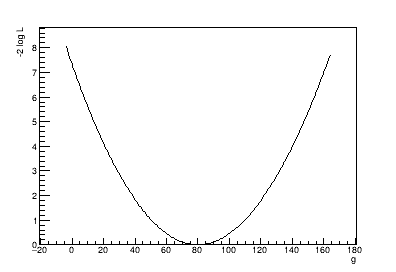

In [8]:
# plot the profiled likelihood with ROOT
from ROOT import TCanvas
c = TCanvas("canvas", "canvas", 400, 300)
lkl_vs_g = p.GetLklVsG() # TGraph holding the profile
lkl_vs_g.SetTitle("")
lkl_vs_g.GetXaxis().SetTitle("g")
lkl_vs_g.GetYaxis().SetTitle("-2 log L")
lkl_vs_g.Draw()
c.Draw() # in pyroot also the canvas has to be drawn

In [9]:
# we can also use matplotlib to plot the likelihood profile
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from ROOT import Double
def get_TGraph_xy(rootTGraph):
    """small function to get TGraph x and y points.
    TGraph.GetX() (or GetY()) returns a C++ array, a pointer, i.e. a memory location unreadable by python.
    """
    x = []
    y = []
    n = rootTGraph.GetN()
    for i in range(n):
        xx = Double(0) # needed to be passed by reference to TGraph's GetPoint()
        yy = Double(0)
        rootTGraph.GetPoint(i, xx, yy)
        x.append(xx)
        y.append(yy)
    return np.asarray(x), np.asarray(y)

In [11]:
g_vals, lkl_vals = get_TGraph_xy(lkl_vs_g)

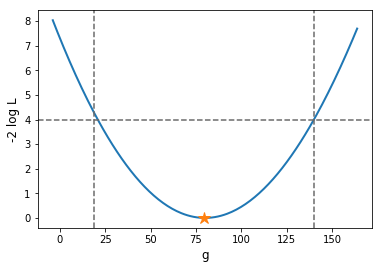

In [12]:
plt.plot(g_vals, lkl_vals, lw=2)
plt.xlabel("g", fontsize=12)
plt.ylabel("-2 log L", fontsize=12)
# plot minimised value with a star
plt.plot(g_min, np.min(lkl_vals), ls="", marker="*", markersize=13)
# plot the errors 
plt.axvline(g_min - g_err, ls="--", color="dimgray")
plt.axvline(g_min + g_err, ls="--", color="dimgray")
plt.axhline(error_def, ls="--", color="dimgray")
plt.show()

### Confront gLike results with other methods
Let us confront `gLike` significance with the one returned by the Li and Ma formula, and minimum and errors by those computed with the Rolke method.

In [13]:
# glike significance
glike_sig = np.sqrt(lkl_vs_g.Eval(0))
# LiMa significance (gammapy)
from gammapy.stats import significance_on_off
lima_sig = significance_on_off(n_on, n_off, tau)

In [14]:
# Rolke method
from ROOT import TRolke
rolke = TRolke(0.9544)
# remember when passing by reference, define first the variable as ROOT.Double
rolke_g_low = Double(0)
rolke_g_up = Double(0)
rolke.SetPoissonBkgKnownEff(n_on, n_off, tau, 1)
rolke.GetLimits(rolke_g_low, rolke_g_up)
rolke_g_min = units_of_g * (rolke_g_low + rolke_g_up) / 2
rolke_g_err = units_of_g * (rolke_g_up - rolke_g_low) / 2

In [15]:
# print and compare results
print(f"gLike significance = {glike_sig:.2f}")
print(f"Li & Ma significance = {lima_sig:.2f}")
print("\n")
print(f"gLike minimum, g = {g_min:.2f} +\- {g_err:.2f}")
print(f"Rolke minimum, g = {rolke_g_min:.2f} +\- {rolke_g_err:.2f}")
print(f"error defined at {np.sqrt(error_def)} sigmas")

gLike significance = 2.70
Li & Ma significance = 2.70


gLike minimum, g = 79.58 +\- 60.48
Rolke minimum, g = 80.48 +\- 59.56
error defined at 2.0 sigmas


### set uncertainties on detection efficiency and ON/OFF exposure ratio
Let us modify the likelihood assuming that the detection efficiency and the exposure ratio have their own distributions with mean 0 and sigma 0.1, let us modify and re-run the likelihood estimation

In [16]:
sigma_eff  = 0.1
sigma_tau  = 0.1

p.SetDEff(sigma_eff)
p.SetDTau(sigma_tau)
p.ComputeLklVsG()

7.511854293821425

Lkl::ComputeLklVsG (PoissonLkl) Message: Finding minimum of -2logL... 
Lkl::MinimizeLkl (PoissonLkl) Message: minimizing -2logL
Lkl::CallMinimization (PoissonLkl) Results: Trial #1, g: 4.00e+01 +/- 3.56e+01 (8.00e+01 +/- 7.12e+01); b: 9.00e+01 +/- 2.61e+01; tau: 1.00e+00 +/- 2.00e-01; eff: 1.00e+00 +/- 2.00e-01; -2logL = 7.51165; iflag = 0 (converged)
Lkl::ComputeLklVsG (PoissonLkl) Message: computing -2logL in 200 points between g=-10.3497(-20.6993), and g=90.3508(180.702), this could take a while
.................... Completed 200 points
Lkl::ComputeLklVsG (PoissonLkl) Message: g_min = 39.7475 +/- 37.1452 (79.4951 +/- 74.2905), -2logLmin = 7.51185


In [17]:
p.PrintOverview()

 *  Name              = PoissonLkl
 *  Status            = 0 (converged)
 *  Delta(2logL)      = 4
 *  # of parameters   = 4 (4 free):
 *                  g = 39.7475 +/- 37.1452 (79.4951 +/- 74.2905)
 *                  b = 90.1232 +/- 0.0948683
 *                tau = 0.999306 +/- 0.01
 *                eff = 1.00056 +/- 0.01
 *  Units of G        = 2
 *  -2logL_min        = 7.51185


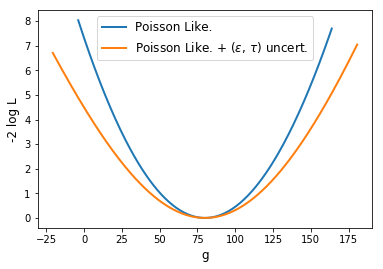

In [18]:
# fetch the value from the modified likelihood and plot them
lkl_vs_g_unc = p.GetLklVsG()
g_vals_unc, lkl_vals_unc = get_TGraph_xy(lkl_vs_g_unc)

plt.plot(g_vals, lkl_vals, lw=2, label="Poisson Like.")
plt.plot(g_vals_unc, lkl_vals_unc, lw=2, label="Poisson Like. + " + r"$(\epsilon,\,\tau)$" + " uncert.")
plt.legend(fontsize=12)
plt.xlabel("g", fontsize=12)
plt.ylabel("-2 log L", fontsize=12)
plt.show()